In [1]:
!pip install pennylane typing_extensions

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn rustworkx

In [3]:
!pip install kagglehub

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijayveersingh/kepler-and-tess-exoplanet-data")

print("Path to dataset files:", path)

DATA_PATH = str(path) + '/'

Using Colab cache for faster access to the 'kepler-and-tess-exoplanet-data' dataset.
Path to dataset files: /kaggle/input/kepler-and-tess-exoplanet-data


✅ PennyLane 0.44.0 | Qubits=4 | Camadas=6 | Protocolo Orbit
Variância explicada pelos 4 componentes principais: 100.0%
Treino balanceado: 4134 amostras (+1: 2067 | -1: 2067)
Teste: 658 amostras (+1: 518 | -1: 140)
🚀 Iniciando treinamento Orbit-VQC...
  ❄️  Camada 0 congelada | step=21 | J=0.9088

✅ Treinamento concluído | 45 steps | Custo final = 0.8580


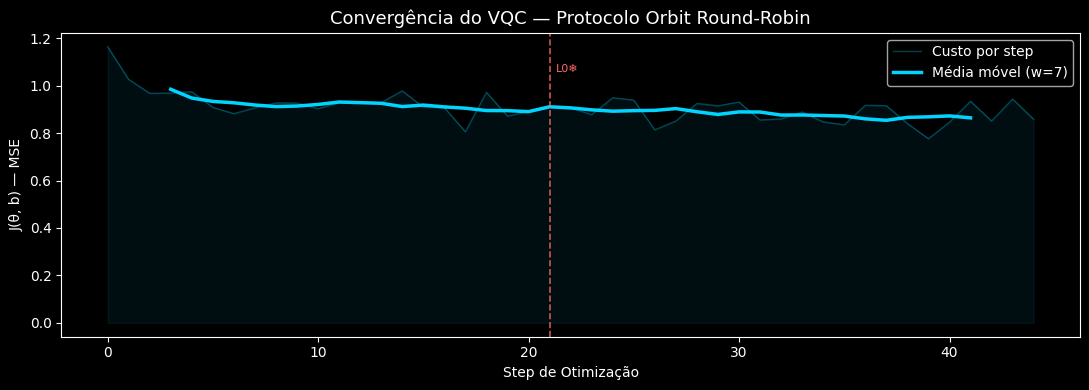

━━━━━━━━━━━━ Métricas Finais ━━━━━━━━━━━━
  MCC (teste)  : +0.3617
  Acurácia     : 0.8131
  Parâmetros   : 73

                     precision    recall  f1-score   support

     False Positive       0.60      0.36      0.45       140
Confirmed/Candidate       0.84      0.94      0.89       518

           accuracy                           0.81       658
          macro avg       0.72      0.65      0.67       658
       weighted avg       0.79      0.81      0.79       658



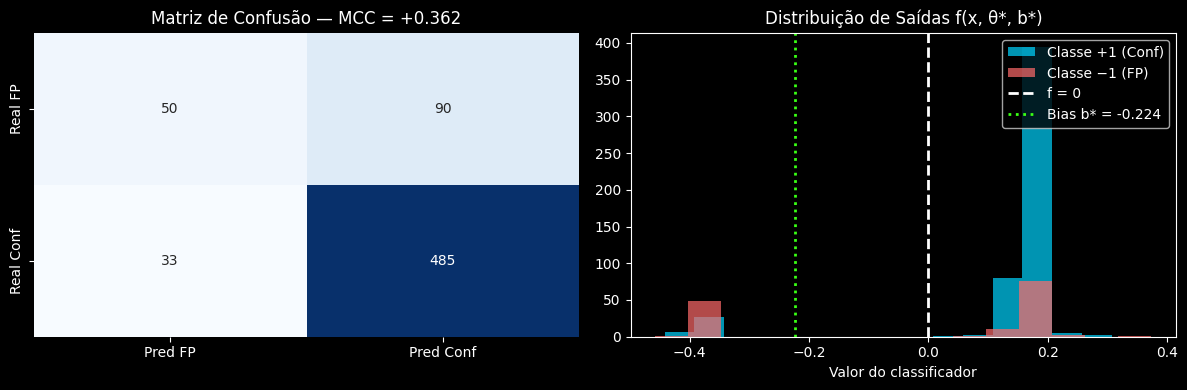

Features TOI disponíveis: ['pl_orbper', 'pl_rade', 'pl_eqt', 'st_rad', 'st_logg', 'st_teff', 'pl_insol']

Previsões TOI: 7211 candidatos a exoplanetas
       toi    pl_rade  pl_orbper
0  1000.01   5.818163   2.171348
1  1001.01  11.215400   1.931646
2  1002.01  23.752900   1.867557
3  1003.01        NaN   2.743230
4  1004.01  11.311300   3.573014
5  1005.01   6.544490   4.550720
6  1006.01   8.695090   2.504792
7  1007.01  14.775200   6.998921
8  1008.01   3.196210   2.048376
9  1009.01        NaN   1.960028

Resultados salvos em 'toi_predictions_vqc.csv'


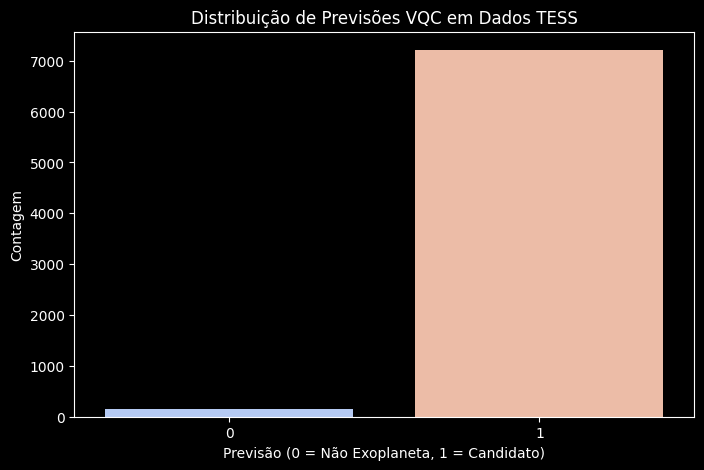

━━━━━━ Recursos do Circuito VQC ━━━━━━━━━━━━━━━━━━━━
  Qubits          : 4
  Camadas (L)     : 6
  Profundidade    : 31
  Operações       : 49
  CNOTs (ansatz)  : 24
  Parâmetros      : 73
0: ─╭IQPEmbedding(M0)──Rot(-0.16,0.07,-0.15)─╭●───────╭X──Rot(-0.09,0.13,-0.03)──╭●───────╭X ···
1: ─├IQPEmbedding(M0)──Rot(0.16,-0.04,0.05)──╰X─╭●────│───Rot(0.18,-0.02,0.13)───╰X─╭●────│─ ···
2: ─├IQPEmbedding(M0)──Rot(0.00,0.06,0.05)──────╰X─╭●─│───Rot(-0.13,-0.01,-0.06)────╰X─╭●─│─ ···
3: ─╰IQPEmbedding(M0)──Rot(-0.03,0.03,-0.01)───────╰X─╰●──Rot(-0.04,0.17,0.03)─────────╰X─╰● ···

0: ··· ──Rot(-0.09,0.14,-0.04)──╭●───────╭X──Rot(-0.04,0.12,0.02)──╭●───────╭X ···
1: ··· ──Rot(0.21,0.04,0.18)────╰X─╭●────│───Rot(0.24,0.06,0.23)───╰X─╭●────│─ ···
2: ··· ──Rot(-0.16,-0.02,-0.11)────╰X─╭●─│───Rot(-0.18,0.05,-0.12)────╰X─╭●─│─ ···
3: ··· ──Rot(-0.09,0.15,-0.05)────────╰X─╰●──Rot(-0.01,0.12,0.01)────────╰X─╰● ···

0: ··· ──Rot(-0.02,0.04,0.03)──╭●───────╭X──Rot(-0.04,0.05,0.02)──╭●───────╭X─┤  <Z>
1: ·

In [8]:
# Orbit-VQC: Classificador Quântico Variacional para Exoplanetas
# Integração com dados Kepler (KOI) e TESS (TOI)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, accuracy_score
import pennylane as qml
from pennylane import numpy as pnp
import os

# Configuração visual
plt.style.use('dark_background')
ACCENT    = '#00D4FF'
SECONDARY = '#FF6B6B'
GREEN     = '#39FF14'

# ═══════════════════════════════════════════════════════════════════════════════
# 1. CARREGAMENTO DOS DATOS (mesmo do código original)
# ═══════════════════════════════════════════════════════════════════════════════

# Carregar KOI (Kepler Object of Interest)
koi_table = pd.read_csv(f"{DATA_PATH}q1_q8_koi_2025.02.03_04.12.15.csv",
                        skiprows=1, delimiter=",", comment="#")

# Feature Engineering - Insolação
koi_table['koi_insol'] = koi_table['koi_steff']**4 / koi_table['koi_period']**2

# Features selecionadas (mesmas do código original)
features = ["koi_period", "koi_prad", "koi_teq", "koi_srad", "koi_slogg", "koi_steff", "koi_insol"]

# Mapeamento de rótulos: CONFIRMED/CANDIDATE = 1, FALSE POSITIVE = 0
# Para VQC, convertemos para {-1, +1} conforme convenção quântica
koi_table["label"] = koi_table["koi_disposition"].map({"CONFIRMED": 1, "FALSE POSITIVE": 0, "CANDIDATE": 1})

# Imputação de valores faltantes
imputer = SimpleImputer(strategy='mean')
koi_table[features] = imputer.fit_transform(koi_table[features])

# Remover linhas sem rótulo
koi_table = koi_table.dropna(subset=["label"])

# ═══════════════════════════════════════════════════════════════════════════════
# 2. CONFIGURAÇÃO DO VQC E HIPERPARÂMETROS
# ═══════════════════════════════════════════════════════════════════════════════

q      = 4       # Número de qubits (dimensão reduzida por PCA)
L      = 6       # Camadas do ansatz
cycles = 3       # Ciclos do protocolo Orbit
η      = 0.05    # Learning rate Adam
ε      = 0.001   # Limiar de Selective Freezing
STEPS_PER_CYCLE = 15
BATCH  = 50
SEED   = 42

np.random.seed(SEED)

print(f'✅ PennyLane {qml.__version__} | Qubits={q} | Camadas={L} | Protocolo Orbit')

# ═══════════════════════════════════════════════════════════════════════════════
# 3. PRÉ-PROCESSAMENTO PARA VQC (PCA + Normalização Quântica)
# ═══════════════════════════════════════════════════════════════════════════════

# Preparar dados
X_raw = koi_table[features].values
y_raw = koi_table["label"].values

# Converter rótulos {0,1} → {-1, +1} para VQC
y_raw = y_raw * 2 - 1

# PCA: Reduzir para q componentes (1 feature por qubit)
pca = PCA(n_components=q, random_state=SEED)
X_low = pca.fit_transform(X_raw)
print(f'Variância explicada pelos {q} componentes principais: {pca.explained_variance_ratio_.sum():.1%}')

# Normalização L2 (projeta na hiperesfera unitária)
norms = np.linalg.norm(X_low, axis=1, keepdims=True)
X_norm = X_low / np.where(norms == 0, 1, norms)

# Escala para [0, π] (compatível com ângulos de rotação quântica - Angle Encoding)
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scl = scaler.fit_transform(X_norm)

# Split estratificado
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scl, y_raw, test_size=0.2, stratify=y_raw, random_state=SEED
)

# Balanceamento de classes (oversampling da classe minoritária)
mask_min = y_tr == -1
X_min, y_min = X_tr[mask_min], y_tr[mask_min]
X_maj, y_maj = X_tr[~mask_min], y_tr[~mask_min]

if len(X_min) > 0 and len(X_maj) > 0:
    X_min_up, y_min_up = resample(
        X_min, y_min, replace=True, n_samples=len(X_maj), random_state=SEED
    )
    X_tr = np.vstack([X_maj, X_min_up])
    y_tr = np.concatenate([y_maj, y_min_up])
    idx = np.random.permutation(len(X_tr))
    X_tr, y_tr = X_tr[idx], y_tr[idx]

print(f'Treino balanceado: {len(X_tr)} amostras (+1: {(y_tr==1).sum()} | -1: {(y_tr==-1).sum()})')
print(f'Teste: {len(X_te)} amostras (+1: {(y_te==1).sum()} | -1: {(y_te==-1).sum()})')

# ═══════════════════════════════════════════════════════════════════════════════
# 4. ARQUITETURA QUÂNTICA (IQP Embedding + Strongly Entangling Layers)
# ═══════════════════════════════════════════════════════════════════════════════

dev = qml.device('default.qubit', wires=q)

def statepreparation(x):
    """
    IQP Embedding: Mapeia dados clássicos para espaço de Hilbert quântico
    U_Φ(x) = [exp(i∑φ_S(x)∏Z_k) H^⊗n]^r
    """
    qml.IQPEmbedding(x, wires=range(q), n_repeats=2)

def ansatz_layer(w):
    """
    Strongly Entangling Layer: Rot(φ,θ,ω) = Rz(ω)Ry(θ)Rz(φ) + CNOTs circulares
    """
    for i in range(q):
        qml.Rot(*w[i], wires=i)
    if q > 1:
        for i in range(q - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[q - 1, 0])  # Fecha o anel

@qml.qnode(dev, diff_method='best')
def circuit(θ, x):
    statepreparation(x)
    for w in θ:
        ansatz_layer(w)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(θ, b, x):
    """f(x, θ, b) = ⟨Z⟩ + b"""
    return circuit(θ, x) + b

def cost_mse(θ, b, X_b, y_b):
    """Função de custo: MSE em mini-batch"""
    preds = pnp.array([variational_classifier(θ, b, xi) for xi in X_b])
    return pnp.mean((preds - y_b) ** 2)

# ═══════════════════════════════════════════════════════════════════════════════
# 5. PROTOCOLO ORBIT ROUND-ROBIN COM SELECTIVE FREEZING
# ═══════════════════════════════════════════════════════════════════════════════

def train_orbit_vqc():
    """
    Treinamento Orbit: Otimiza uma camada por vez (Round-Robin)
    Congela camadas quando ΔJ < ε (Selective Freezing)
    """
    # Inicialização com perturbação gaussiana pequena
    θ_list = [
        pnp.random.normal(0, 0.01, (q, 3), requires_grad=True)
        for _ in range(L)
    ]
    b = pnp.array(0.0, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=η)

    active = list(range(L))  # Conjunto de camadas ativas
    prev_J = {l: 2.0 for l in range(L)}
    loss_history = []
    freeze_log = {}
    step_global = 0

    for cycle in range(cycles):
        for step in range(STEPS_PER_CYCLE):
            if not active:
                print(f'  → Convergência total no ciclo {cycle}, step {step}')
                break

            # Round-Robin: seleciona camada ativa ciclicamente
            l_turn = active[step % len(active)]

            # Mini-batch estocástico
            idx_b = np.random.choice(len(X_tr), min(BATCH, len(X_tr)), replace=False)
            X_b = pnp.array(X_tr[idx_b])
            y_b = pnp.array(y_tr[idx_b], dtype=float)

            # Congela camadas inativas
            θ_fixed = [
                pnp.array(np.array(w), requires_grad=False)
                for w in θ_list
            ]

            def partial_cost(wl, bias):
                θ_tmp = [
                    θ_fixed[i] if i != l_turn else wl
                    for i in range(L)
                ]
                θ_arr = pnp.array(np.stack([np.array(w) for w in θ_tmp]))
                return cost_mse(θ_arr, bias, X_b, y_b)

            (wl_new, b_new), J = opt.step_and_cost(partial_cost, θ_list[l_turn], b)

            θ_list[l_turn] = wl_new
            b = b_new

            # Selective Freezing
            ΔJ = abs(float(J) - prev_J[l_turn])
            if ΔJ < ε and l_turn in active:
                active.remove(l_turn)
                freeze_log[l_turn] = step_global
                print(f'  ❄️  Camada {l_turn} congelada | step={step_global} | J={J:.4f}')

            prev_J[l_turn] = float(J)
            loss_history.append(float(J))
            step_global += 1

    θ_star = pnp.array(np.stack([np.array(w) for w in θ_list]))
    return θ_star, b, loss_history, freeze_log

# Treinamento
print('🚀 Iniciando treinamento Orbit-VQC...')
θ_star, b_star, hist, freeze_log = train_orbit_vqc()
print(f'\n✅ Treinamento concluído | {len(hist)} steps | Custo final = {hist[-1]:.4f}')

# ═══════════════════════════════════════════════════════════════════════════════
# 6. VISUALIZAÇÃO DO TREINAMENTO
# ═══════════════════════════════════════════════════════════════════════════════

def smooth(arr, w=5):
    return np.convolve(arr, np.ones(w) / w, mode='valid')

fig, ax = plt.subplots(figsize=(11, 4))
steps = np.arange(len(hist))

ax.plot(steps, hist, color=ACCENT, lw=1, alpha=0.3, label='Custo por step')
sm = smooth(hist, w=7)
ax.plot(np.arange(len(sm)) + 3, sm, color=ACCENT, lw=2.5, label='Média móvel (w=7)')
ax.fill_between(steps, hist, alpha=0.07, color=ACCENT)

# Marca camadas congeladas
for layer, s in freeze_log.items():
    ax.axvline(s, color=SECONDARY, lw=1.2, linestyle='--', alpha=0.8)
    ax.text(s + 0.3, max(hist) * 0.91, f'L{layer}❄', color=SECONDARY, fontsize=8)

ax.set_title('Convergência do VQC — Protocolo Orbit Round-Robin', fontsize=13)
ax.set_xlabel('Step de Otimização')
ax.set_ylabel('J(θ, b) — MSE')
ax.legend()
plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# 7. AVALIAÇÃO NO CONJUNTO DE TESTE
# ═══════════════════════════════════════════════════════════════════════════════

raw_te = np.array([variational_classifier(θ_star, b_star, xi) for xi in X_te])
y_pred_te = np.sign(raw_te)

# Converter previsões {-1, +1} → {0, 1} para métricas
y_pred_te_binary = (y_pred_te + 1) // 2
y_te_binary = (y_te + 1) // 2

mcc_te = matthews_corrcoef(y_te, y_pred_te)
acc_te = accuracy_score(y_te_binary, y_pred_te_binary)

print('━━━━━━━━━━━━ Métricas Finais ━━━━━━━━━━━━')
print(f'  MCC (teste)  : {mcc_te:+.4f}')
print(f'  Acurácia     : {acc_te:.4f}')
print(f'  Parâmetros   : {L * q * 3 + 1}')
print()
print(classification_report(y_te_binary, y_pred_te_binary,
                           target_names=['False Positive', 'Confirmed/Candidate']))

# Matriz de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm = confusion_matrix(y_te_binary, y_pred_te_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred FP', 'Pred Conf'],
            yticklabels=['Real FP', 'Real Conf'], ax=axes[0])
axes[0].set_title(f'Matriz de Confusão — MCC = {mcc_te:+.3f}', fontsize=12)

# Distribuição das saídas
axes[1].hist(raw_te[y_te == 1], bins=15, alpha=0.7, color=ACCENT, label='Classe +1 (Conf)')
axes[1].hist(raw_te[y_te == -1], bins=15, alpha=0.7, color=SECONDARY, label='Classe −1 (FP)')
axes[1].axvline(0, color='white', lw=2, linestyle='--', label='f = 0')
axes[1].axvline(float(b_star), color=GREEN, lw=2, linestyle=':',
                label=f'Bias b* = {float(b_star):.3f}')
axes[1].set_title('Distribuição de Saídas f(x, θ*, b*)', fontsize=12)
axes[1].set_xlabel('Valor do classificador')
axes[1].legend()

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════════
# 8. APLICAÇÃO AOS DATOS TESS (TOI)
# ═══════════════════════════════════════════════════════════════════════════════

# Carregar TOI
toi_table = pd.read_csv(f"{DATA_PATH}TOI_2025.02.03_06.18.31.csv",
                        skiprows=1, delimiter=",", comment="#")

# Mapeamento de features KOI → TOI
feature_mapping = {
    "koi_period": "pl_orbper",
    "koi_prad": "pl_rade",
    "koi_teq": "pl_eqt",
    "koi_srad": "st_rad",
    "koi_slogg": "st_logg",
    "koi_steff": "st_teff",
    "koi_insol": "pl_insol"
}

# Selecionar features disponíveis
toi_features = []
for koi_feat, toi_feat in feature_mapping.items():
    if toi_feat in toi_table.columns:
        toi_features.append(toi_feat)

print(f"Features TOI disponíveis: {toi_features}")

if len(toi_features) == len(features):
    # Preparar dados TOI
    new_data = toi_table[toi_features].copy()
    reverse_mapping = {v: k for k, v in feature_mapping.items()}
    new_data = new_data.rename(columns=reverse_mapping)

    # Imputação
    new_data[features] = imputer.transform(new_data[features])

    # Aplicar mesmas transformações do treino (PCA + scaler)
    X_toi_raw = new_data[features].values
    X_toi_low = pca.transform(X_toi_raw)  # Usar PCA já treinado
    norms = np.linalg.norm(X_toi_low, axis=1, keepdims=True)
    X_toi_norm = X_toi_low / np.where(norms == 0, 1, norms)
    X_toi_scl = scaler.transform(X_toi_norm)

    # Previsões quânticas
    predictions = (np.array([variational_classifier(θ_star, b_star, xi) for xi in X_toi_scl]) > 0).astype(int)

    toi_table["Predicted_Label"] = predictions

    print(f"\nPrevisões TOI: {(predictions == 1).sum()} candidatos a exoplanetas")
    print(toi_table[toi_table["Predicted_Label"] == 1][["toi", "pl_rade", "pl_orbper"]].head(10))

    # Salvar resultados
    toi_table.to_csv("toi_predictions_vqc.csv", index=False)
    print(f"\nResultados salvos em 'toi_predictions_vqc.csv'")

    # Visualização das previsões TOI
    plt.figure(figsize=(8, 5))
    sns.countplot(x="Predicted_Label", data=toi_table, palette="coolwarm")
    plt.title("Distribuição de Previsões VQC em Dados TESS")
    plt.xlabel("Previsão (0 = Não Exoplaneta, 1 = Candidato)")
    plt.ylabel("Contagem")
    plt.show()
else:
    print(f"Aviso: Apenas {len(toi_features)}/{len(features)} features disponíveis em TOI")

# ═══════════════════════════════════════════════════════════════════════════════
# 9. ANÁLISE DE RECURSOS DO CIRCUITO
# ═══════════════════════════════════════════════════════════════════════════════

spec = qml.specs(circuit)(θ_star, pnp.array(X_te[0]))

# Directly access attributes from the CircuitSpecs object and its resources attribute
depth = spec.resources.depth
n_gates = spec.resources.num_gates

n_cnot = L * q  # CNOTs do ansatz

print('━━━━━━ Recursos do Circuito VQC ━━━━━━━━━━━━━━━━━━━━')
print(f'  Qubits          : {q}')
print(f'  Camadas (L)     : {L}')
print(f'  Profundidade    : {depth}')
print(f'  Operações       : {n_gates}')
print(f'  CNOTs (ansatz)  : {n_cnot}')
print(f'  Parâmetros      : {L * q * 3 + 1}')

print(qml.draw(circuit)(θ_star, pnp.array(X_te[0])))